In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from shroomdk import ShroomDK
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler 
from scipy.stats import zscore
from scipy.spatial.distance import cdist
from sklearn.preprocessing import PowerTransformer

In [15]:
#Setting up shroomDK powered by Flipside
my_address = '0x06ED7E490144D4b74BD1C9F33F69DA402603540E'
key = '74d495c5-4a92-4d2f-baf4-b0296d042dcb'
sdk = ShroomDK(key)

In [16]:
def create_sql_list(df,col):
    df_new = ""
    inputs = list(df[col])
    i = 0
    for row in inputs:
        if i < len(inputs) - 1:
            df_new = df_new + "lower('" + row + "'),"
        else:
            df_new = df_new + "lower('" + row + "')"
        i += 1
    df_new = df_new + ""
    return df_new   

In [17]:
import math
def find_airdropers():
    sql = f"""with temp as (SELECT 
  block_timestamp as bt,
  ORIGIN_FROM_ADDRESS as airdrop_recipient,
  raw_amount / power(10, decimals) as amount,
  case when raw_amount/pow(10,18) between 776 and 777 then 1 else 0 END as "Optimism Users",
  case when raw_amount/pow(10,18) between 2469 and 2470 then 1 else 0 END as "Repeated Optimism Users",
  case when raw_amount/pow(10,18) between 271 and 272 then 1 else 0 END as "DAO Voters",
  case when raw_amount/pow(10,18) between 1190 and 1191 then 1 else 0 END as "Multisig Signers",
  case when raw_amount/pow(10,18) between 555 and 556 then 1 else 0 END as "Gitcoin Donors (on L1)",
  case when raw_amount/pow(10,18) between 409 and 410 then 1 else 0 END as "Users Priced Out of Ethereum",
  CASE WHEN delegator IS NULL THEN 0 ELSE 1 END AS delegator,
  contract_address as token
  FROM optimism.core.fact_token_transfers
  LEFT outer JOIN optimism.core.dim_contracts ON address = contract_address
  LEFT JOIN (SELECT delegator FROM optimism.core.fact_delegations) ON ORIGIN_FROM_ADDRESS = delegator
  WHERE symbol LIKE 'OP'
  AND from_address LIKE lower('0xFeDFAF1A10335448b7FA0268F56D2B44DBD357de')
  AND ORIGIN_FUNCTION_SIGNATURE LIKE '0x2e7ba6ef'
  ),
  
  airdrop_recipients as (
  SELECT
  airdrop_recipient,
  token,
  MIN(bt) as bt,
  SUM(amount) as amount,
  MAX("Optimism Users") as "Optimism Users",
  MAX("Repeated Optimism Users") as "Repeated Optimism Users",
  MAX("DAO Voters") as "DAO Voters",
  MAX("Multisig Signers") as "Multisig Signers",
  MAX("Gitcoin Donors (on L1)") as "Gitcoin Donors (on L1)",
  MAX("Users Priced Out of Ethereum") as "Users Priced Out of Ethereum",
  MAX(delegator) as delegator
  FROM temp
  GROUP BY airdrop_recipient, token
  ),
  
  in_transfers_all as (SELECT 
  to_address,
  COUNT(in_volume) as no_in_transfers,
  SUM(in_volume) as in_volume
  FROM (SELECT 
  to_address,
  raw_amount / power(10, decimals) as in_volume 
  FROM optimism.core.fact_token_transfers
  INNER JOIN airdrop_recipients ON airdrop_recipient = TO_ADDRESS
  LEFT outer JOIN optimism.core.dim_contracts
  ON address = contract_address
  WHERE symbol LIKE 'OP'
  and block_timestamp > bt) f GROUP BY 1),
  
  in_transfers_30 as (SELECT 
  to_address,
  COUNT(in_volume) as no_in_transfers_30,
  SUM(in_volume) as in_volume_30
  FROM (SELECT 
  to_address,
  raw_amount / power(10, decimals) as in_volume 
  FROM optimism.core.fact_token_transfers
  INNER JOIN airdrop_recipients ON airdrop_recipient = TO_ADDRESS
  LEFT outer JOIN optimism.core.dim_contracts
  ON address = contract_address
  WHERE datediff(day,bt, block_timestamp) < 30
  and block_timestamp > bt
  and symbol LIKE 'OP')  GROUP BY 1
  ),

  out_transfers_30 as (SELECT 
  from_address,
  COUNT(out_volume) as no_out_transfers_30,
  SUM(out_volume) as out_volume_30
  FROM (SELECT 
  from_address,
  raw_amount / power(10, decimals) as out_volume 
  FROM optimism.core.fact_token_transfers
  INNER JOIN airdrop_recipients ON airdrop_recipient =from_address
  LEFT outer JOIN optimism.core.dim_contracts
  ON address = contract_address
  WHERE datediff(day,bt, block_timestamp) < 30
  and symbol LIKE 'OP') f GROUP BY 1
  ),

  in_transfers_7 as (SELECT 
  to_address,
  COUNT(in_volume) as no_in_transfers_7,
  SUM(in_volume) as in_volume_7
  FROM (SELECT 
  to_address,
  raw_amount / power(10, decimals) as in_volume 
  FROM optimism.core.fact_token_transfers
  INNER JOIN airdrop_recipients ON airdrop_recipient = TO_ADDRESS
  LEFT outer JOIN optimism.core.dim_contracts
  ON address = contract_address
  WHERE datediff(day,bt, block_timestamp) < 7
  and block_timestamp > bt
  and symbol LIKE 'OP')  GROUP BY 1
  ),
  
  in_transfers_2 as (SELECT 
  to_address,
  COUNT(in_volume) as no_in_transfers_2,
  SUM(in_volume) as in_volume_2
  FROM (SELECT 
  to_address,
  raw_amount / power(10, decimals) as in_volume 
  FROM optimism.core.fact_token_transfers
  INNER JOIN airdrop_recipients ON airdrop_recipient = TO_ADDRESS
  LEFT outer JOIN optimism.core.dim_contracts
  ON address = contract_address
  WHERE datediff(day,bt, block_timestamp) < 2
  and block_timestamp > bt
  and symbol LIKE 'OP')  GROUP BY 1
  ),


  out_transfers_7 as (SELECT 
  from_address,
  COUNT(out_volume) as no_out_transfers_7,
  SUM(out_volume) as out_volume_7
  FROM (SELECT 
  from_address,
  raw_amount / power(10, decimals) as out_volume 
  FROM optimism.core.fact_token_transfers
  INNER JOIN airdrop_recipients ON airdrop_recipient =from_address
  LEFT outer JOIN optimism.core.dim_contracts
  ON address = contract_address
  WHERE datediff(day,bt, block_timestamp) < 7
  and symbol LIKE 'OP') f GROUP BY 1
  ),
  
    out_transfers_2 as (SELECT 
  from_address,
  COUNT(out_volume) as no_out_transfers_2,
  SUM(out_volume) as out_volume_2
  FROM (SELECT 
  from_address,
  raw_amount / power(10, decimals) as out_volume 
  FROM optimism.core.fact_token_transfers
  INNER JOIN airdrop_recipients ON airdrop_recipient =from_address
  LEFT outer JOIN optimism.core.dim_contracts
  ON address = contract_address
  WHERE datediff(day,bt, block_timestamp) < 2
  and symbol LIKE 'OP') f GROUP BY 1
  ),

  out_transfers_all as (SELECT
  FROM_ADDRESS,
  COUNT(*) as no_out_transfers,
  SUM(out_volume) as out_volume
  FROM (SELECT 
  FROM_ADDRESS,
  raw_amount / power(10, decimals) as out_volume 
  FROM optimism.core.fact_token_transfers
  INNER JOIN airdrop_recipients ON airdrop_recipient = FROM_ADDRESS
  LEFT outer JOIN optimism.core.dim_contracts
  ON address = contract_address
  WHERE symbol LIKE 'OP'
 ) GROUP BY from_address
  )
  
    SELECT
    airdrop_recipient,
    bt as time_airdrop_claimed,
    current_date - DATE(bt) as days_since_claim,
    amount,
    "Optimism Users",
    "Repeated Optimism Users",
    "DAO Voters",
    "Multisig Signers",
    "Gitcoin Donors (on L1)",
    "Users Priced Out of Ethereum",
     delegator,
     amount - COALESCE(out_volume,0) + COALESCE(in_volume,0) as curent_op_balance,
    ((amount - COALESCE(out_volume,0) + COALESCE(in_volume,0)) - amount) / amount as op_percent_change,
    ((amount - COALESCE(out_volume_7,0) + COALESCE(in_volume_7,0)) - amount) / amount as op_percent_change_7,
     CASE WHEN ((amount - COALESCE(out_volume,0) + COALESCE(in_volume,0)) - amount) / amount < -.89 THEN 1 ELSE 0 END AS dumped,
     CASE WHEN (amount - COALESCE(out_volume,0) + COALESCE(in_volume,0)) < amount THEN 1 ELSE 0 END AS sold_some_op,
     CASE WHEN (amount - COALESCE(out_volume,0) + COALESCE(in_volume,0)) > amount THEN 1 ELSE 0 END AS increased_op,
     CASE WHEN (amount - COALESCE(out_volume,0) + COALESCE(in_volume,0)) = amount THEN 1 ELSE 0 END AS hodl,
     CASE WHEN ((amount - COALESCE(out_volume_30,0) + COALESCE(in_volume_30,0)) - amount) / amount < -.89 THEN 1 ELSE 0 END AS dumped_30,
     CASE WHEN (amount - COALESCE(out_volume_30,0) + COALESCE(in_volume_30,0)) < amount THEN 1 ELSE 0 END AS sold_some_op_30,
     CASE WHEN (amount - COALESCE(out_volume_30,0) + COALESCE(in_volume_30,0)) > amount THEN 1 ELSE 0 END AS increased_op_30,
     CASE WHEN ((amount - COALESCE(out_volume_7,0) + COALESCE(in_volume_7,0)) - amount) / amount < -.89 THEN 1 ELSE 0 END AS dumped_7,
     CASE WHEN (amount - COALESCE(out_volume_7,0) + COALESCE(in_volume_7,0)) < amount THEN 1 ELSE 0 END AS sold_some_op_7,
     CASE WHEN (amount - COALESCE(out_volume_7,0) + COALESCE(in_volume_7,0)) > amount THEN 1 ELSE 0 END AS increased_op_7,
     CASE WHEN ((amount - COALESCE(out_volume_2,0) + COALESCE(in_volume_2,0)) - amount) / amount < -.89 THEN 1 ELSE 0 END AS dumped_2 
  FROM airdrop_recipients
  LEFT JOIN out_transfers_all oa on airdrop_recipient = oa.FROM_ADDRESS
  LEFT JOIN in_transfers_all ia on airdrop_recipient = ia.to_address
  LEFT JOIN out_transfers_30 ot on airdrop_recipient = ot.FROM_ADDRESS
  LEFT JOIN in_transfers_30  it on airdrop_recipient = it.to_address
  LEFT JOIN out_transfers_7 ott on airdrop_recipient = ott.FROM_ADDRESS
  LEFT JOIN in_transfers_7  itt on airdrop_recipient = itt.to_address
  LEFT JOIN out_transfers_2 ottt on airdrop_recipient = ottt.FROM_ADDRESS
  LEFT JOIN in_transfers_2  ittt on airdrop_recipient = ittt.to_address
  """
    query_result_set = sdk.query(sql,page_number=1)
    query_result_set2 = sdk.query(sql,page_number=2)
    hoppers = pd.DataFrame(query_result_set.records)
    hoppers2 = pd.DataFrame(query_result_set2.records)
    hoppers = pd.concat([hoppers,hoppers2])
    return hoppers 

In [18]:
#Hop Airdrop Info
df_hop_airdrop = find_airdropers()
print(len(df_hop_airdrop))
print(len(df_hop_airdrop['airdrop_recipient'].unique()))

149435
149435


In [19]:
df_hop_airdrop['Multi Qualifier'] = df_hop_airdrop.apply(lambda x: 1 if
    (x["optimism users"]== 0) &
    (x["repeated optimism users"]== 0) &
    (x["dao voters"] == 0) &
    (x["multisig signers"]== 0) & 
    (x["gitcoin donors (on l1)"]== 0) &  
    (x["users priced out of ethereum"] == 0) else 0, axis = 1) 

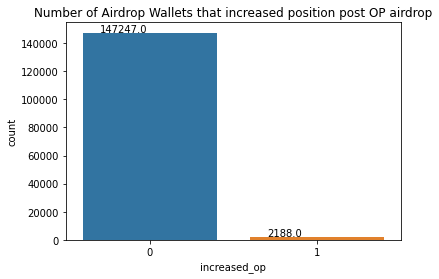

In [20]:
plt.title('Number of Airdrop Wallets that increased position post OP airdrop')
plt.ylabel('Number of Wallets')
ax = sns.countplot(x=df_hop_airdrop["increased_op"])
for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))
plt.show()

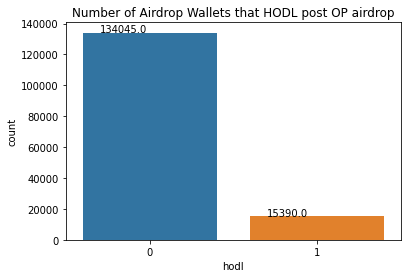

In [21]:
plt.title('Number of Airdrop Wallets that HODL post OP airdrop')
plt.ylabel('Number of Wallets')
ax = sns.countplot(x=df_hop_airdrop["hodl"])
for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))
plt.show()

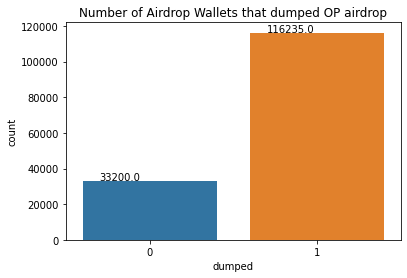

In [22]:
plt.title('Number of Airdrop Wallets that dumped OP airdrop')
plt.ylabel('Number of Wallets')
ax = sns.countplot(x=df_hop_airdrop["dumped"])
for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))
plt.show()

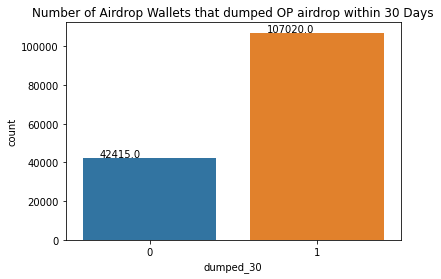

In [23]:
plt.title('Number of Airdrop Wallets that dumped OP airdrop within 30 Days')
plt.ylabel('Number of Wallets')
ax = sns.countplot(x=df_hop_airdrop["dumped_30"])
for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))
plt.show()

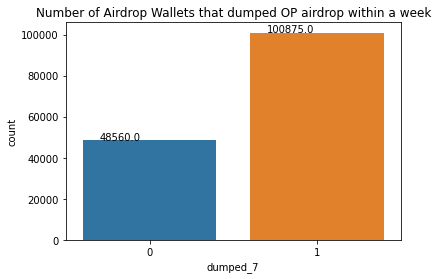

In [24]:
plt.title('Number of Airdrop Wallets that dumped OP airdrop within a week')
plt.ylabel('Number of Wallets')
ax = sns.countplot(x=df_hop_airdrop["dumped_7"])
for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))
plt.show()

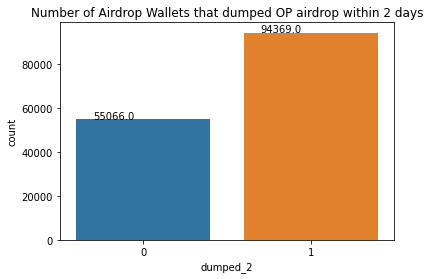

In [25]:
plt.title('Number of Airdrop Wallets that dumped OP airdrop within 2 days')
plt.ylabel('Number of Wallets')
ax = sns.countplot(x=df_hop_airdrop["dumped_2"])
for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))
plt.show()

In [26]:
94369/ (94369+55066)

0.6315053367684946

In [29]:
xx = pd.DataFrame(df_hop_airdrop.groupby('dumped')['airdrop_recipient'].count()).rename(columns={'airdrop_recipient':'Total_Wallets_Dumped'}).reset_index()
xx7 = pd.DataFrame(df_hop_airdrop.groupby('dumped_30')['airdrop_recipient'].count()).rename(columns={'airdrop_recipient':'Total_Wallets_Dumped_30'}).reset_index()
xx30 = pd.DataFrame(df_hop_airdrop.groupby('dumped_7')['airdrop_recipient'].count()).rename(columns={'airdrop_recipient':'Total_Wallets_Dumped_7'}).reset_index()
xx = pd.merge(xx,xx7,left_on='dumped',right_on='dumped_30')
xx= pd.merge(xx,xx30,left_on='dumped',right_on='dumped_7')
xx  = xx.drop(columns=['dumped','dumped_30','dumped_7'])
xx['Total_Wallets_Dumped'] = xx['Total_Wallets_Dumped'] / len(df_hop_airdrop)
xx['Total_Wallets_Dumped_30'] = xx['Total_Wallets_Dumped_30'] / len(df_hop_airdrop)
xx['Total_Wallets_Dumped_7'] = xx['Total_Wallets_Dumped_7'] / len(df_hop_airdrop)
xx

,Total_Wallets_Dumped,Total_Wallets_Dumped_30,Total_Wallets_Dumped_7
0,0.220836,0.282563,0.323797
1,0.779164,0.717437,0.676203


In [30]:
df_hop_airdrop.columns

Index(['airdrop_recipient', 'time_airdrop_claimed', 'days_since_claim',
       'amount', 'optimism users', 'repeated optimism users', 'dao voters',
       'multisig signers', 'gitcoin donors (on l1)',
       'users priced out of ethereum', 'delegator', 'curent_op_balance',
       'op_percent_change', 'op_percent_change_7', 'dumped', 'sold_some_op',
       'increased_op', 'hodl', 'dumped_30', 'sold_some_op_30',
       'increased_op_30', 'dumped_7', 'sold_some_op_7', 'increased_op_7',
       'Multi Qualifier'],
      dtype='object')

In [31]:
yy = pd.DataFrame()
cols = ['Multi Qualifier','optimism users','repeated optimism users','dao voters','multisig signers','gitcoin donors (on l1)', 'users priced out of ethereum']
for col in cols:
    airdrop = df_hop_airdrop[df_hop_airdrop[col] == 1]
    xx = pd.DataFrame(airdrop.groupby('dumped')['airdrop_recipient'].count()).rename(columns={'airdrop_recipient':'Total_Wallets_Dumped'}).reset_index()
    xx7 = pd.DataFrame(airdrop.groupby('dumped_30')['airdrop_recipient'].count()).rename(columns={'airdrop_recipient':'Total_Wallets_Dumped_30'}).reset_index()
    xx30 = pd.DataFrame(airdrop.groupby('dumped_7')['airdrop_recipient'].count()).rename(columns={'airdrop_recipient':'Total_Wallets_Dumped_7'}).reset_index()
    xx = pd.merge(xx,xx7,left_on='dumped',right_on='dumped_30')
    xx= pd.merge(xx,xx30,left_on='dumped',right_on='dumped_7')
    xx  = xx.drop(columns=['dumped','dumped_30','dumped_7'])
    xx['Total_Wallets_Dumped'] = xx['Total_Wallets_Dumped'] / len(airdrop)
    xx['Total_Wallets_Dumped_30'] = xx['Total_Wallets_Dumped_30'] / len(airdrop)
    xx['Total_Wallets_Dumped_7'] = xx['Total_Wallets_Dumped_7'] / len(airdrop)
    xx['OP Airdrop Type'] = col
    yy = pd.concat([xx,yy])
yy = yy.reset_index()
yy[yy['index'] == 1]

,index,Total_Wallets_Dumped,Total_Wallets_Dumped_30,Total_Wallets_Dumped_7,OP Airdrop Type
1,1,0.814297,0.767661,0.738465,users priced out of ethereum
3,1,0.796476,0.746396,0.704431,gitcoin donors (on l1)
5,1,0.775164,0.731411,0.708649,multisig signers
7,1,0.745654,0.693452,0.666068,dao voters
9,1,0.706825,0.621106,0.565370,repeated optimism users
11,1,0.804395,0.741460,0.695881,optimism users
13,1,0.749775,0.676462,0.629249,Multi Qualifier


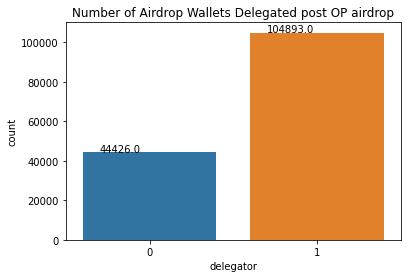

In [32]:
plt.title('Number of Airdrop Wallets Delegated post OP airdrop')
plt.ylabel('Number of Wallets')
ax = sns.countplot(x=df_hop_airdrop["delegator"])
for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))
plt.show()

In [33]:
yy = pd.DataFrame()
cols = ['Multi Qualifier','optimism users','repeated optimism users','dao voters','multisig signers','gitcoin donors (on l1)', 'users priced out of ethereum']
for col in cols:
    airdrop = df_hop_airdrop[df_hop_airdrop[col] == 1]
    xx = pd.DataFrame(airdrop.groupby('delegator')['airdrop_recipient'].count()).rename(columns={'airdrop_recipient':'Wallets_Delegate'}).reset_index()
    xx['Wallets_Delegate'] = xx['Wallets_Delegate'] / len(airdrop)
    xx['OP Airdrop Type'] = col
    yy = pd.concat([xx,yy])
yy = yy.reset_index()
yy[yy['index'] == 1]


,index,delegator,Wallets_Delegate,OP Airdrop Type
1,1,1,0.702154,users priced out of ethereum
3,1,1,0.646022,gitcoin donors (on l1)
5,1,1,0.568538,multisig signers
7,1,1,0.708733,dao voters
9,1,1,0.783811,repeated optimism users
11,1,1,0.688758,optimism users
13,1,1,0.729803,Multi Qualifier


In [34]:
yy = pd.DataFrame()

cols = ['optimism users','repeated optimism users','dao voters','multisig signers','gitcoin donors (on l1)', 'users priced out of ethereum']
for col in cols:
    airdrop = df_hop_airdrop[df_hop_airdrop[col] == 1]
    airdrop = airdrop[airdrop['delegator'] == 1]
    xx = pd.DataFrame(airdrop.groupby('dumped')['airdrop_recipient'].count()).rename(columns={'airdrop_recipient':'Wallets_Delegate'}).reset_index()
    xx['Wallets_Delegate'] = xx['Wallets_Delegate'] / len(airdrop)
    xx['OP Airdrop Type'] = col
    yy = pd.concat([xx,yy])
yy = yy.reset_index()
yy[yy['index'] == 1]


,index,dumped,Wallets_Delegate,OP Airdrop Type
1,1,1,0.774854,users priced out of ethereum
3,1,1,0.717355,gitcoin donors (on l1)
5,1,1,0.704181,multisig signers
7,1,1,0.687360,dao voters
9,1,1,0.651465,repeated optimism users
11,1,1,0.743959,optimism users


In [35]:
#Op Info
def get_op_info():
    sql = f""" with temp as (SELECT 
  block_timestamp as bt,
  ORIGIN_FROM_ADDRESS as airdrop_recipient,
  raw_amount / power(10, decimals) as amount,
  case when raw_amount/pow(10,18) between 776 and 777 then 1 else 0 END as "Optimism Users",
  case when raw_amount/pow(10,18) between 2469 and 2470 then 1 else 0 END as "Repeated Optimism Users",
  case when raw_amount/pow(10,18) between 271 and 272 then 1 else 0 END as "DAO Voters",
  case when raw_amount/pow(10,18) between 1190 and 1191 then 1 else 0 END as "Multisig Signers",
  case when raw_amount/pow(10,18) between 555 and 556 then 1 else 0 END as "Gitcoin Donors (on L1)",
  case when raw_amount/pow(10,18) between 409 and 410 then 1 else 0 END as "Users Priced Out of Ethereum",
  CASE WHEN delegator IS NULL THEN 0 ELSE 1 END AS delegator,
  contract_address as token
  FROM optimism.core.fact_token_transfers
  LEFT outer JOIN optimism.core.dim_contracts ON address = contract_address
  LEFT JOIN (SELECT delegator FROM optimism.core.fact_delegations) ON ORIGIN_FROM_ADDRESS = delegator
  WHERE symbol LIKE 'OP'
  AND from_address LIKE lower('0xFeDFAF1A10335448b7FA0268F56D2B44DBD357de')
  AND ORIGIN_FUNCTION_SIGNATURE LIKE '0x2e7ba6ef'
  ),
  
  airdrop_recipients as (
  SELECT
  airdrop_recipient,
  token,
  MIN(bt) as bt,
  SUM(amount) as amount,
  MAX("Optimism Users") as "Optimism Users",
  MAX("Repeated Optimism Users") as "Repeated Optimism Users",
  MAX("DAO Voters") as "DAO Voters",
  MAX("Multisig Signers") as "Multisig Signers",
  MAX("Gitcoin Donors (on L1)") as "Gitcoin Donors (on L1)",
  MAX("Users Priced Out of Ethereum") as "Users Priced Out of Ethereum",
  MAX(delegator) as delegator
  FROM temp
  GROUP BY airdrop_recipient, token
  ),
  op as (SELECT 
    block_timestamp,
    tx_hash,
    1 as tx_hash_to,
    0 as tx_hash_from,
    from_address as "user",
    to_address as interaction,
    to_address as  no_interactions_to,
    '' as no_interactions_from,
    tx_fee
    FROM optimism.core.fact_transactions
    INNER JOIN airdrop_recipients ON airdrop_recipient = from_address
    WHERE block_timestamp < '2022-04-26'

    UNION ALL

    SELECT
    block_timestamp,
    tx_hash,
    0 as tx_hash_to,
    1 as tx_hash_from,
    to_address as "user",
    from_address as interaction,
    '' as  no_interactions_to,
    from_address as no_interactions_from,
    tx_fee
    FROM optimism.core.fact_transactions
    INNER JOIN airdrop_recipients ON airdrop_recipient = to_address
    WHERE block_timestamp < '2022-04-26')


    SELECT  
    "user",
    COUNT(DISTINCT(tx_hash)) as total_txs,
    SUM(tx_hash_to) as total_txs_to,
    SUM(tx_hash_from) as total_txs_from,
    SUM(tx_hash_to) / COUNT(DISTINCT(tx_hash)) as perc_tx_to,
    COUNT(DISTINCT(DATE(block_timestamp))) as active_days,
    COUNT(DISTINCT(DATE_TRUNC('WEEK',block_timestamp))) as active_weeks,
    CURRENT_DATE - MAX(DATE(block_timestamp)) as days_since_last_used,
    CURRENT_DATE - MIN(DATE(block_timestamp)) as days_since_first_used,
    MAX(DATE(block_timestamp)) - MIN(DATE(block_timestamp)) as activity_span_op,
    COUNT(DISTINCT(interaction)) as distinct_interaction,
    COUNT(DISTINCT(no_interactions_to)) as no_interactions_to,
    COUNT(DISTINCT(no_interactions_from)) as no_interactions_from,
    COUNT(DISTINCT(no_interactions_to)) / COUNT(DISTINCT(no_interactions_from)) as to_from_ratio,
    COUNT(DISTINCT(tx_hash)) / COUNT(DISTINCT(DATE(block_timestamp))) as txs_per_day,
    SUM(tx_fee) as total_fees
    FROM op 
    GROUP BY "user"
   
    """
    query_result_set = sdk.query(sql,page_number = 1)
    query_result_set2 = sdk.query(sql,page_number = 2)
    owner = pd.DataFrame(query_result_set.records)
    owner2 = pd.DataFrame(query_result_set2.records)
    owner = pd.concat([owner,owner2])
    
    return owner

# Adress Info

In [36]:
def get_eth_address_info():
    sql = f""" with temp as (SELECT 
  block_timestamp as bt,
  ORIGIN_FROM_ADDRESS as airdrop_recipient,
  raw_amount / power(10, decimals) as amount,
  case when raw_amount/pow(10,18) between 776 and 777 then 1 else 0 END as "Optimism Users",
  case when raw_amount/pow(10,18) between 2469 and 2470 then 1 else 0 END as "Repeated Optimism Users",
  case when raw_amount/pow(10,18) between 271 and 272 then 1 else 0 END as "DAO Voters",
  case when raw_amount/pow(10,18) between 1190 and 1191 then 1 else 0 END as "Multisig Signers",
  case when raw_amount/pow(10,18) between 555 and 556 then 1 else 0 END as "Gitcoin Donors (on L1)",
  case when raw_amount/pow(10,18) between 409 and 410 then 1 else 0 END as "Users Priced Out of Ethereum",
  CASE WHEN delegator IS NULL THEN 0 ELSE 1 END AS delegator,
  contract_address as token
  FROM optimism.core.fact_token_transfers
  LEFT outer JOIN optimism.core.dim_contracts ON address = contract_address
  LEFT JOIN (SELECT delegator FROM optimism.core.fact_delegations) ON ORIGIN_FROM_ADDRESS = delegator
  WHERE symbol LIKE 'OP'
  AND from_address LIKE lower('0xFeDFAF1A10335448b7FA0268F56D2B44DBD357de')
  AND ORIGIN_FUNCTION_SIGNATURE LIKE '0x2e7ba6ef'
  ),
  
  airdrop_recipients as (
  SELECT
  airdrop_recipient,
  token,
  MIN(bt) as bt,
  SUM(amount) as amount,
  MAX("Optimism Users") as "Optimism Users",
  MAX("Repeated Optimism Users") as "Repeated Optimism Users",
  MAX("DAO Voters") as "DAO Voters",
  MAX("Multisig Signers") as "Multisig Signers",
  MAX("Gitcoin Donors (on L1)") as "Gitcoin Donors (on L1)",
  MAX("Users Priced Out of Ethereum") as "Users Priced Out of Ethereum",
  MAX(delegator) as delegator
  FROM temp
  GROUP BY airdrop_recipient, token
  ),

    
    addy as (SELECT
    tx_hash,
    EVENT_NAME,
    origin_from_address as address,
    block_timestamp,
    origin_to_address as interact,
    contract_address
    FROM ethereum.core.fact_event_logs
    INNER JOIN airdrop_recipients ON airdrop_recipient = origin_from_address
    AND block_timestamp < '2022-04-26'

    UNION ALL

    SELECT 
    tx_hash,
    EVENT_NAME,
    origin_to_address as address,
    block_timestamp,
    origin_from_address as interact,
    contract_address
    FROM ethereum.core.fact_event_logs
    INNER JOIN airdrop_recipients ON airdrop_recipient = origin_to_address
    AND block_timestamp < '2022-04-26'
    ),
    
    from_add as (
    SELECT 
    address,
      COUNT(DISTINCT(f.tx_hash)) as no_owner_tx_from,
      COUNT(DISTINCT(f.interact)) as unique_addresses_interact_from,
      CURRENT_DATE -  MIN(DATE(f.block_timestamp)) as days_since_first_tx_from,
      CURRENT_DATE -  MAX(DATE(f.block_timestamp)) as days_since_last_tx_from
    FROM (SELECT
    tx_hash,
    from_address as address,
    block_timestamp,
    to_address as interact
    FROM ethereum.core.fact_transactions
    INNER JOIN airdrop_recipients ON airdrop_recipient = from_address
    AND block_timestamp < '2022-04-26') f
     GROUP BY address),

    to_add as (
    SELECT 
    address,
  COUNT(DISTINCT(f.tx_hash)) as no_owner_tx_to,
  COUNT(DISTINCT(f.interact)) as unique_addresses_interact_to,
  CURRENT_DATE -  MIN(DATE(f.block_timestamp)) as days_since_first_tx_to,
  CURRENT_DATE -  MAX(DATE(f.block_timestamp)) as days_since_last_tx_to
    FROM (SELECT
    tx_hash,
    to_address as address,
    block_timestamp,
    from_address as interact
    FROM ethereum.core.fact_transactions
    INNER JOIN airdrop_recipients ON airdrop_recipient = to_address
    AND block_timestamp < '2022-04-26') f
     GROUP BY address),

  op_bridge as (
    SELECT 
    address,
    COUNT(distinct(tx_hash)) as no_bridges,
    SUM(amount_bridged) as total_amount_bridge,
    COUNT(DISTINCT(block_timestamp)) as distinct_bridge_days,
    MAX(deposit_small_eth) as bridge_small_amount,
    MIN(deposit_small_eth) as bridge_small_amount_all
    FROM (SELECT
    origin_from_address as address,
    block_timestamp,
    tx_hash,
    t.amount as amount_bridged,
    CASE WHEN t.amount < .1 THEN 1 ELSE 0 END as deposit_small_eth
    FROM ethereum.core.ez_eth_transfers t
    INNER JOIN airdrop_recipients ON airdrop_recipient = origin_from_address
    AND block_timestamp < '2022-04-26'
    and eth_to_address = '0x99c9fc46f92e8a1c0dec1b1747d010903e884be1') f
    GROUP BY address),



    temp2 as (SELECT 
      a.address,
      CURRENT_DATE -  MIN(DATE(a.block_timestamp)) as days_since_first_tx,
      CURRENT_DATE -  MAX(DATE(a.block_timestamp)) as days_since_last_tx,
       MAX(DATE(a.block_timestamp)) - MIN(DATE(a.block_timestamp)) as activity_span,
      COUNT(DISTINCT(a.tx_hash)) as no_owner_tx,
      COUNT(DISTINCT(a.contract_address)) as no_contracts,
      COUNT(DISTINCT(a.EVENT_NAME)) as no_events,
      COUNT(DISTINCT(a.interact)) as unique_addresses_interact 
    FROM addy a
    GROUP BY a.address) 
    
    
    SELECT 
    a.address,
    days_since_first_tx,
    days_since_last_tx,
    activity_span,
    no_owner_tx,
    no_contracts,
    no_events,
    unique_addresses_interact,
    no_owner_tx_from,
    unique_addresses_interact_from,
    days_since_first_tx_from,
    days_since_last_tx_from,
    no_owner_tx_to,
    unique_addresses_interact_to,
    days_since_first_tx_to,
    days_since_last_tx_to,
    no_owner_tx_from / (no_owner_tx+1)  as percent_from_tx,
    unique_addresses_interact_from / (unique_addresses_interact+1) as unique_addresses_interact_from_percent,
    days_since_last_tx_from - days_since_last_tx_to as days_since_last_diff,
    no_bridges,
    total_amount_bridge,
    bridge_small_amount,
    distinct_bridge_days,
    bridge_small_amount_all
    FROM temp2 a
    LEFT JOIN to_add t ON  t.address = a.address
    LEFT JOIN from_add f ON f.address = a.address
    LEFT JOIN op_bridge o ON o.address = a.address
    """
    query_result_set = sdk.query(sql)
    query_result_set2 = sdk.query(sql, page_number =2)

    owner = pd.DataFrame(query_result_set.records)
    owner2 = pd.DataFrame(query_result_set2.records)
    owner = pd.concat([owner,owner2])
    return owner

# Interaction Info

In [37]:
def get_interactions():
    sql = f"""with temp as (SELECT 
    block_timestamp as bt,
    ORIGIN_FROM_ADDRESS as airdrop_recipient,
    raw_amount / power(10, decimals) as amount,
    case when raw_amount/pow(10,18) between 776 and 777 then 1 else 0 END as "Optimism Users",
    case when raw_amount/pow(10,18) between 2469 and 2470 then 1 else 0 END as "Repeated Optimism Users",
    case when raw_amount/pow(10,18) between 271 and 272 then 1 else 0 END as "DAO Voters",
    case when raw_amount/pow(10,18) between 1190 and 1191 then 1 else 0 END as "Multisig Signers",
    case when raw_amount/pow(10,18) between 555 and 556 then 1 else 0 END as "Gitcoin Donors (on L1)",
    case when raw_amount/pow(10,18) between 409 and 410 then 1 else 0 END as "Users Priced Out of Ethereum",
    CASE WHEN delegator IS NULL THEN 0 ELSE 1 END AS delegator,
    contract_address as token
    FROM optimism.core.fact_token_transfers
    LEFT outer JOIN optimism.core.dim_contracts ON address = contract_address
    LEFT JOIN (SELECT delegator FROM optimism.core.fact_delegations) ON ORIGIN_FROM_ADDRESS = delegator
    WHERE symbol LIKE 'OP'
    AND from_address LIKE lower('0xFeDFAF1A10335448b7FA0268F56D2B44DBD357de')
    AND ORIGIN_FUNCTION_SIGNATURE LIKE '0x2e7ba6ef'
    ),

    airdrop_recipients as (
    SELECT
    airdrop_recipient,
    token,
    MIN(bt) as bt,
    SUM(amount) as amount,
    MAX("Optimism Users") as "Optimism Users",
    MAX("Repeated Optimism Users") as "Repeated Optimism Users",
    MAX("DAO Voters") as "DAO Voters",
    MAX("Multisig Signers") as "Multisig Signers",
    MAX("Gitcoin Donors (on L1)") as "Gitcoin Donors (on L1)",
    MAX("Users Priced Out of Ethereum") as "Users Priced Out of Ethereum",
    MAX(delegator) as delegator
    FROM temp
    GROUP BY airdrop_recipient, token
    ),


    addy as (SELECT
    tx_hash,
    from_address as address,
    block_timestamp,
    to_address as interact
    FROM ethereum.core.fact_transactions
    INNER JOIN airdrop_recipients ON airdrop_recipient = from_address
    AND block_timestamp < '2022-04-26'

    UNION ALL

    SELECT 
    tx_hash,
    to_address as address,
    block_timestamp,
    from_address as interact
    FROM ethereum.core.fact_transactions
    INNER JOIN airdrop_recipients ON airdrop_recipient = to_address
    AND block_timestamp < '2022-04-26'
    ),

    interact_air as (SELECT  
    address,
    COUNT(DISTINCT(interact)) as no_other_airdrop_wallets_interacted_with,
    1 as interacted_with_other_airdrop_wallet
    FROM addy a
    INNER JOIN airdrop_recipients r ON airdrop_recipient = interact
    GROUP BY address),

    total_txs as (SELECT 
    *,
    row_number() OVER (PARTITION BY address ORDER BY block_timestamp) as row_number
    FROM addy
    ORDER BY block_timestamp),

    no_address_share_first_tx as (SELECT
    interact,
    COUNT(DISTINCT(address)) as no_address_share_first_tx,
    1 as shares_wallet_first_tx
    FROM total_txs
    WHERE row_number = 1  
    GROUP BY interact),

    left_em as (select
    address,
    no_address_share_first_tx,
    shares_wallet_first_tx
    FROM (SELECT address, interact FROM total_txs WHERE row_number =1) f
    INNER JOIN no_address_share_first_tx t ON f.interact = t.interact
    )

    SELECT 
    airdrop_recipient as address,
    no_address_share_first_tx,
    no_other_airdrop_wallets_interacted_with,
    CASE WHEN no_address_share_first_tx > 1 THEN 1 ELSE 0 END as shares_wallet_first_tx
    FROM airdrop_recipients
    LEFT JOIN left_em l ON airdrop_recipient = l.address
    LEFT JOIN interact_air i ON airdrop_recipient = i.address
    """
    query_result_set = sdk.query(sql)
    query_result_set2 = sdk.query(sql, page_number =2)

    owner = pd.DataFrame(query_result_set.records)
    owner2 = pd.DataFrame(query_result_set2.records)
    owner = pd.concat([owner,owner2])
    return owner

In [38]:
#Op Info
def get_op_info_post():
    sql = f""" with temp as (SELECT 
  block_timestamp as bt,
  ORIGIN_FROM_ADDRESS as airdrop_recipient,
  raw_amount / power(10, decimals) as amount,
  case when raw_amount/pow(10,18) between 776 and 777 then 1 else 0 END as "Optimism Users",
  case when raw_amount/pow(10,18) between 2469 and 2470 then 1 else 0 END as "Repeated Optimism Users",
  case when raw_amount/pow(10,18) between 271 and 272 then 1 else 0 END as "DAO Voters",
  case when raw_amount/pow(10,18) between 1190 and 1191 then 1 else 0 END as "Multisig Signers",
  case when raw_amount/pow(10,18) between 555 and 556 then 1 else 0 END as "Gitcoin Donors (on L1)",
  case when raw_amount/pow(10,18) between 409 and 410 then 1 else 0 END as "Users Priced Out of Ethereum",
  CASE WHEN delegator IS NULL THEN 0 ELSE 1 END AS delegator,
  contract_address as token
  FROM optimism.core.fact_token_transfers
  LEFT outer JOIN optimism.core.dim_contracts ON address = contract_address
  LEFT JOIN (SELECT delegator FROM optimism.core.fact_delegations) ON ORIGIN_FROM_ADDRESS = delegator
  WHERE symbol LIKE 'OP'
  AND from_address LIKE lower('0xFeDFAF1A10335448b7FA0268F56D2B44DBD357de')
  AND ORIGIN_FUNCTION_SIGNATURE LIKE '0x2e7ba6ef'
  ),
  
  airdrop_recipients as (
  SELECT
  airdrop_recipient,
  token,
  MIN(bt) as bt,
  SUM(amount) as amount,
  MAX("Optimism Users") as "Optimism Users",
  MAX("Repeated Optimism Users") as "Repeated Optimism Users",
  MAX("DAO Voters") as "DAO Voters",
  MAX("Multisig Signers") as "Multisig Signers",
  MAX("Gitcoin Donors (on L1)") as "Gitcoin Donors (on L1)",
  MAX("Users Priced Out of Ethereum") as "Users Priced Out of Ethereum",
  MAX(delegator) as delegator
  FROM temp
  GROUP BY airdrop_recipient, token
  ),
  op as (SELECT 
    block_timestamp,
    tx_hash,
    1 as tx_hash_to,
    0 as tx_hash_from,
    from_address as "user",
    to_address as interaction,
    to_address as  no_interactions_to,
    '' as no_interactions_from,
    tx_fee
    FROM optimism.core.fact_transactions
    INNER JOIN airdrop_recipients ON airdrop_recipient = from_address
    WHERE block_timestamp > '2022-04-26'

    UNION ALL

    SELECT
    block_timestamp,
    tx_hash,
    0 as tx_hash_to,
    1 as tx_hash_from,
    to_address as "user",
    from_address as interaction,
    '' as  no_interactions_to,
    from_address as no_interactions_from,
    tx_fee
    FROM optimism.core.fact_transactions
    INNER JOIN airdrop_recipients ON airdrop_recipient = to_address
    WHERE block_timestamp > '2022-04-26')


    SELECT  
    "user",
    COUNT(DISTINCT(tx_hash)) as total_txs,
    SUM(tx_hash_to) as total_txs_to,
    SUM(tx_hash_from) as total_txs_from,
    SUM(tx_hash_to) / COUNT(DISTINCT(tx_hash)) as perc_tx_to,
    COUNT(DISTINCT(DATE(block_timestamp))) as active_days,
    COUNT(DISTINCT(DATE_TRUNC('WEEK',block_timestamp))) as active_weeks,
    CURRENT_DATE - MAX(DATE(block_timestamp)) as days_since_last_used,
    CURRENT_DATE - MIN(DATE(block_timestamp)) as days_since_first_used,
    MAX(DATE(block_timestamp)) - MIN(DATE(block_timestamp)) as activity_span_op,
    COUNT(DISTINCT(interaction)) as distinct_interaction,
    COUNT(DISTINCT(no_interactions_to)) as no_interactions_to,
    COUNT(DISTINCT(no_interactions_from)) as no_interactions_from,
    COUNT(DISTINCT(no_interactions_to)) / COUNT(DISTINCT(no_interactions_from)) as to_from_ratio,
    COUNT(DISTINCT(tx_hash)) / COUNT(DISTINCT(DATE(block_timestamp))) as txs_per_day,
    SUM(tx_fee) as total_fees
    FROM op 
    GROUP BY "user"
   
    """
    query_result_set = sdk.query(sql,page_number = 1)
    query_result_set2 = sdk.query(sql,page_number = 2)
    owner = pd.DataFrame(query_result_set.records)
    owner2 = pd.DataFrame(query_result_set2.records)
    owner = pd.concat([owner,owner2])
    
    return owner

In [39]:
# max_number =round(len(df_hop_airdrop) / 1000)
i = 0
df_bridge = pd.DataFrame()
df_address = pd.DataFrame()
df_interact = pd.DataFrame()
df_bridge_post = pd.DataFrame()
# while i < max_number:
#     first= i*1000
#     second= 1000 + i*1000
#     if first % 10000 == 0:
#         print (f"{i / max_number } % Complete")
#     string =create_sql_list(df_hop_airdrop[first:second],'airdrop_recipient')
    #querying data and concentating
bridge = get_op_info()
address = get_eth_address_info()
interact = get_interactions()
bridge = get_op_info_post()
df_bridge = pd.concat([df_bridge, bridge])
df_address = pd.concat([df_address,address])
df_interact = pd.concat([df_interact,interact])
df_bridge_post = pd.concat([df_bridge_post, df_bridge])
i += 1

In [40]:
df_interact

,address,no_address_share_first_tx,no_other_airdrop_wallets_interacted_with,shares_wallet_first_tx
0,0xe3f4f3ad70c1190ec480554bbc3ed30285ae0610,1.0,2.0,0
1,0xb77f8fc6e80013f1ba146e868a3918c267867422,953.0,2.0,1
2,0x4ed549c9aa7fec07827b5bfee4f8314dc9cb976f,953.0,1.0,1
3,0x0a8ef7a45560b4d43023b0d3e1968060f6a04d65,1.0,5.0,0
4,0xde208627b38b9795284efcc14d8b8c313462876a,2.0,5.0,1
...,...,...,...,...
49314,0xde144227a6cb269d47226f97fa8ddb682d3dc54b,2.0,1.0,1
49315,0x948707a5b07f740c577f7d7249c355983de70f75,1.0,2.0,0
49316,0xb39bd5be9a666d355710370a661d1d46d901323b,1.0,3.0,0
49317,0x3082f27581a2449268a14af56d810cacd9984ec1,449.0,10.0,1


In [41]:
len(df_address['address'].unique())

136954

In [42]:
sns.color_palette("Spectral", as_cmap=True)

In [43]:
#Airdrop Info

token = ['ENS','1INCH','Ribbon',
         'AMP','X2Y2',
         'EULER','BEND','UNI','DYDX']

from_address = [#'0xA35dce3e0E6ceb67a30b8D7f4aEe721C949B5970',
                '0xc18360217d8f7ab5e7c516566761ea12ce7f9d72',
                #'0x5a5ecd062083733c9aa27cb4c5f113c42f730261',
                #'0x0000000000000000000000000000000000000000',
                '0xe295ad71242373c37c5fda7b57f26f9ea1088afe',
                '0x7902e4bfb1eb9F4559d55417Aee1Dc6E4b8cC1Bf',
                '0xF497b83CfBd31E7Ba1Ab646F3B50aE0aF52d03A1',
                '0xe6949137b24ad50cce2cf6b124b3b874449a41fa',
                #'0xcAfE001067cDEF266AfB7Eb5A286dCFD277f3dE5',
                '0xd524e29e3baf5bb085403ca5665301e94387a7e2',
                '0x1b5d2904be3e4711a848be09b17dee89e6a5bc27',
                '0x090d4613473dee047c3f2706764f49e0821d256e',
                '0x639192d54431f8c816368d3fb4107bc168d0e871'
                
                
                ]
contract_address = [#'0xf4d2888d29d722226fafa5d9b24f9164c092421e',
                   '0xc18360217d8f7ab5e7c516566761ea12ce7f9d72',
                   #'0x3b484b82567a09e2588a13d54d032153f0c0aee0',
                   '0x111111111117dc0aa78b770fa6a738034120c302',
                   '0x6123b0049f904d730db3c36a31167d9d4121fa6b',
                    '0x77fba179c79de5b7653f68b5039af940ada60ce0',
                    '0x1e4ede388cbc9f4b5c79681b7f94d36a11abebc9',
                    #'0x090E53c44E8a9b6B1bcA800e881455b921AEC420',
                    '0xd9Fcd98c322942075A5C3860693e9f4f03AAE07b',
                    '0x0d02755a5700414b26ff040e1de35d337df56218',
                    '0x1f9840a85d5aF5bf1D1762F925BDADdC4201F984',
                    '0x92D6C1e31e14520e676a687F0a93788B716BEff5'
                   ]

df_airdrops = pd.DataFrame({
    'Token':token,
    'From Address':from_address,
    'Contract Address': contract_address
})



In [44]:
#functions query airdropers that have dumped a particular token in less than a week of a holding (wallet balence = 0)
def find_airdroppers(token,address,contract,airdropper_df):
    sql = f"""
    with airdrop_recipients as (SELECT --DISTINCT(origin_to_address) AS hop_address
    block_timestamp as bt,
    to_address as airdrop_recipient,
    contract_address as token
    FROM ethereum.core.fact_token_transfers
    WHERE contract_address = lower('{contract}')
    and from_address = lower('{address}')
    )

    SELECT --distinct(user_address)
    ROW_NUMBER() OVER (PARTITION BY user_address ORDER BY bt) as "Row",
    --DATEDIFF(day, bt, block_timestamp) as "Time to Drop",
    user_address as airdrop_recipient,
    prev_bal as amount_dumped
    FROM ethereum.core.ez_balance_deltas
    INNER JOIN airdrop_recipients ON airdrop_recipient = user_address and token = contract_address
    WHERE current_bal = 0
    and DATEDIFF(day, bt, block_timestamp) < 30
    """
    

    query_result_set = sdk.query(sql)
    
    dumpers = pd.DataFrame(query_result_set.records)
    dumpers = dumpers[dumpers["row"] == 1]
    dumpers.columns = [str(col) + '_' + token if col != 'user_address' else col for col in dumpers.columns]

    no_dumpers = len(dumpers)
    print(f'Identifed {no_dumpers} that dumped {token} within a month')
    
    col_name = 'Dumped ' + token
    row_name = 'row_' + token
    dumpers[col_name] = 1
#     print(dumpers.head())
    ids = 'airdrop_recipient' + '_' + token
    airdropper_df = pd.merge(airdropper_df,dumpers,left_on='airdrop_recipient',right_on= ids,how='left')
    airdropper_df = airdropper_df.drop(columns=[ids,row_name])
    no_addresses = airdropper_df.loc[airdropper_df[col_name] == 1,'airdrop_recipient'].unique()
    airdropper_df = airdropper_df.fillna(0)
    
    airdropper_df['Number of Airdrops Dumped'] = airdropper_df['Number of Airdrops Dumped'] + airdropper_df[col_name]
    airdropper_df['Tokens Dumped'] = np.where(airdropper_df[col_name] == 1, airdropper_df['Tokens Dumped'] +", "+ col_name, airdropper_df['Tokens Dumped'])
    
    print(f'Identifed {len(no_addresses)} owner addresses that dumped {token}')
    return airdropper_df, no_dumpers,len(no_addresses)
    

In [45]:
i = 0
dumped = []
add = []
past_dump = df_hop_airdrop[['airdrop_recipient']].copy()
past_dump['Number of Airdrops Dumped'] = 0
past_dump['Tokens Dumped'] = ''
while i < len(df_airdrops):
    token = df_airdrops.loc[i,'Token']
    address = df_airdrops.loc[i,'From Address']
    contract = df_airdrops.loc[i,'Contract Address']
    past_dump, no_dumpers,no_addresses = find_airdroppers(token,address,contract,past_dump)
    dumped.append(no_dumpers)
    add.append(no_addresses)
    i += 1

Identifed 54783 that dumped ENS within a month
Identifed 13682 owner addresses that dumped ENS
Identifed 31848 that dumped 1INCH within a month
Identifed 6280 owner addresses that dumped 1INCH
Identifed 92 that dumped Ribbon within a month
Identifed 35 owner addresses that dumped Ribbon
Identifed 24544 that dumped AMP within a month
Identifed 2908 owner addresses that dumped AMP
Identifed 33075 that dumped X2Y2 within a month
Identifed 12274 owner addresses that dumped X2Y2
Identifed 1870 that dumped EULER within a month
Identifed 806 owner addresses that dumped EULER
Identifed 9832 that dumped BEND within a month
Identifed 3406 owner addresses that dumped BEND
Identifed 82712 that dumped UNI within a month
Identifed 6567 owner addresses that dumped UNI
Identifed 22413 that dumped DYDX within a month
Identifed 5217 owner addresses that dumped DYDX


In [46]:
df_airdrops['# of Dumpers'] = dumped
df_airdrops['# of Addresses'] = add

<AxesSubplot:title={'center':'Histogram of Number of Aridrops previously dumped'}, xlabel='Number of Airdrops Dumped', ylabel='Count'>

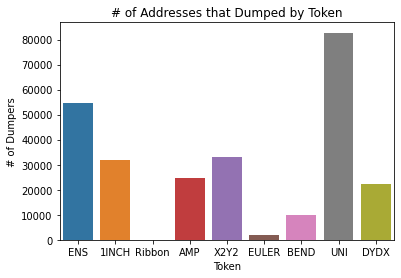

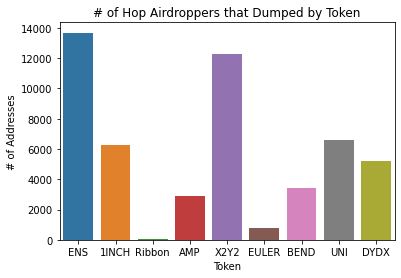

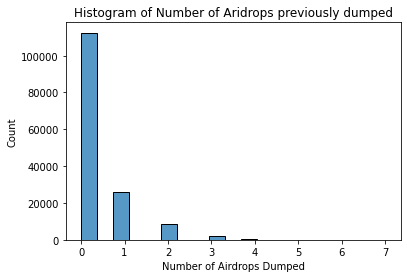

In [47]:
plt.figure()
plt.title('# of Addresses that Dumped by Token')
sns.barplot(data=df_airdrops, x="Token", y="# of Dumpers")
plt.figure()
plt.title('# of Hop Airdroppers that Dumped by Token')
sns.barplot(data=df_airdrops, x="Token", y="# of Addresses")
plt.figure()
plt.title('Histogram of Number of Aridrops previously dumped')
sns.histplot(x='Number of Airdrops Dumped',data=past_dump)

# ITS MERGING TIME

In [48]:
past_dump.to_csv('PastDump_Op.csv')
df_bridge.to_csv('Bridge_Op.csv')
df_address.to_csv('Address_Op.csv')
df_interact.to_csv('Interactions_Op.csv')
df_bridge_post.to_csv('Post Op.csv')
df_hop_airdrop.to_csv('Airdrop.csv')
past_dump

,airdrop_recipient,Number of Airdrops Dumped,Tokens Dumped,amount_dumped_ENS,Dumped ENS,amount_dumped_1INCH,Dumped 1INCH,amount_dumped_Ribbon,Dumped Ribbon,amount_dumped_AMP,...,amount_dumped_X2Y2,Dumped X2Y2,amount_dumped_EULER,Dumped EULER,amount_dumped_BEND,Dumped BEND,amount_dumped_UNI,Dumped UNI,amount_dumped_DYDX,Dumped DYDX
0,0x8de2a3587a6277b855f125af120fa69db3712129,0.0,,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
1,0xc3baf091d7282ab739c8e478e0b1159e90f44220,0.0,,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
2,0x5af84f1318241b4224ecfc9e6d4e97a3118cd38f,0.0,,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
3,0x163e0934d4b1ef0f279989cc81071ec7429cfcff,3.0,", Dumped ENS, Dumped X2Y2, Dumped BEND",80.916879,1.0,0.0,0.0,0.0,0.0,0.000000,...,995.393333,1.0,0.0,0.0,9409.543176,1.0,0.0,0.0,0.000000,0.0
4,0xc6423efdfc0b74eb5f94ae018bbd01634a4051c4,2.0,", Dumped ENS, Dumped AMP",191.884708,1.0,0.0,0.0,0.0,0.0,50.512463,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149314,0x29f38539edd0af82ca268eab907651671a9fcddb,2.0,", Dumped ENS, Dumped DYDX",39.467417,1.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,190.220179,1.0
149315,0x5d5a7e3465b8dcaa2ce7362ea19e8dcad985dd88,0.0,,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
149316,0xbee267272f8be199fefd463708f22ec9a1ff50ab,0.0,,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
149317,0x4d87ef681ab2f717fe0425099d79dfe773d52ca7,0.0,,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0


In [49]:
past_dump = pd.read_csv('PastDump_Op.csv')
df_bridge= pd.read_csv('Bridge_Op.csv')
df_address= pd.read_csv('Address_Op.csv')
df_interact = pd.read_csv('Interactions_Op.csv')
df_hop_airdrop = pd.read_csv('Airdrop.csv')
df_op = pd.read_csv('Post Op.csv')

In [50]:
df = df_hop_airdrop.copy()
df_bridge = df_bridge.drop_duplicates()
df = pd.merge(df, df_bridge,left_on='airdrop_recipient',right_on='user', how = 'left')
df = pd.merge(df, df_address,left_on='airdrop_recipient',right_on='address', how = 'left')
df = pd.merge(df, past_dump,on='airdrop_recipient',how = 'left')
df = pd.merge(df, df_interact,left_on='airdrop_recipient',right_on='address', how = 'left')

In [51]:
df_op.describe()

,Unnamed: 0,total_txs,total_txs_to,total_txs_from,perc_tx_to,active_days,active_weeks,days_since_last_used,days_since_first_used,activity_span_op,distinct_interaction,no_interactions_to,no_interactions_from,to_from_ratio,txs_per_day,total_fees
count,149319.000000,149319.000000,149319.000000,149319.000000,149319.000000,149319.000000,149319.000000,149319.000000,149319.000000,149319.000000,149319.000000,149319.000000,149319.000000,149319.000000,149319.000000,1.493190e+05
mean,41629.713707,48.077344,47.191041,0.894977,0.933093,6.486743,3.838172,85.442978,136.968624,51.525646,9.917070,9.868577,1.660780,6.443265,3.847482,9.634008e-03
std,27696.299949,1278.832436,1277.915687,3.267786,0.106260,12.138663,4.706740,52.704123,19.962564,58.532351,15.831497,15.684455,2.028114,9.853077,9.719566,3.310676e-01
min,0.000000,1.000000,1.000000,0.000000,0.011905,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.016000,1.000000,8.888000e-08
25%,18664.500000,4.000000,4.000000,0.000000,0.875000,1.000000,1.000000,24.000000,135.000000,0.000000,3.000000,3.000000,1.000000,2.000000,2.000000,1.160033e-03
50%,37329.000000,7.000000,6.000000,0.000000,1.000000,2.000000,2.000000,111.000000,135.000000,21.000000,5.000000,5.000000,1.000000,4.000000,3.000000,1.972647e-03
75%,62669.500000,16.000000,15.000000,1.000000,1.000000,6.000000,4.000000,135.000000,136.000000,113.000000,9.000000,9.000000,2.000000,6.000000,4.943920,3.966602e-03
max,99999.000000,150603.000000,150589.000000,380.000000,1.000000,172.000000,25.000000,136.000000,171.000000,171.000000,1509.000000,1509.000000,300.000000,754.500000,1882.952381,6.592612e+01


In [52]:
# for column in df.columns:
#     print(column)

df['Dumped Token'] = df['Number of Airdrops Dumped'].apply(lambda x: 1 if x > 0 else 0)
df['total_txs_from'] = df['total_txs_from'].fillna(0)
df['total_txs'] = df['total_txs'].fillna(0)
df['% OP'] = df['total_txs'] / (df['no_owner_tx'] + df['total_txs'])
df['Never used OP'] = df['% OP'].apply(lambda x: 1 if x == 0 else 0)
df['Did Not Transact on Op'] = df['total_txs_from'].apply(lambda x:1 if x < 1 else 0)
df['Multi'] = df.apply(lambda x: 1 if (x['optimism users'] == 0) & (x['repeated optimism users'] == 0) & (x['dao voters'] == 0) & (x['multisig signers'] == 0) & (x['gitcoin donors (on l1)'] == 0) & (x['users priced out of ethereum'] == 0) else 0, axis =1)
X = df.copy()

cols = ['airdrop_recipient', 'time_airdrop_claimed', 'amount','delegator',
       'curent_op_balance', 'op_percent_change', 'op_percent_change_7',
       'dumped', 'sold_some_op', 'increased_op', 'hodl', 'dumped_30',
       'sold_some_op_30', 'increased_op_30', 'dumped_7', 'sold_some_op_7',
       'increased_op_7', 'Unnamed: 0_x', 'user', 'Unnamed: 0_y',
       'address_x', 'days_since_first_tx',
       'Unnamed: 0_x', 'Unnamed: 0_y', 'address_y','Tokens Dumped','days_since_claim']

X = X.drop(columns = cols)

y = df[['op_percent_change',
'op_percent_change_7',
'dumped',
'sold_some_op',
'increased_op',
'hodl',
'dumped_30',
'sold_some_op_30',
'increased_op_30',
'dumped_7',
'sold_some_op_7',
'increased_op_7']]

In [53]:
X = X.fillna(0)

In [54]:
log_cols = ['no_owner_tx'
           ]
scale_cols = [x for x in X.columns if x not in log_cols]
scale_pipe = make_pipeline(MinMaxScaler())
log_pipe = make_pipeline(PowerTransformer())

transformer = ColumnTransformer(remainder='passthrough',
    transformers=[
        ("scale", scale_pipe, scale_cols),
        ("log_transform", log_pipe, log_cols),
    ]
)

X = X.reset_index(drop = True)
scaled = transformer.fit_transform(X)  

X = pd.DataFrame(scaled, index=X.index, columns=X.columns)


In [55]:
# distortions = []
# inertias = []
# mapping1 = {}
# mapping2 = {}

# K = range(1, 10)
  
# for k in K:
#     # Building and fitting the model
#     kmeanModel = KMeans(n_clusters=k).fit(X)
#     kmeanModel.fit(X)
  
#     distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
#                                         'euclidean'), axis=1)) / X.shape[0])
#     inertias.append(kmeanModel.inertia_)
  
#     mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
#                                    'euclidean'), axis=1)) / X.shape[0]
#     mapping2[k] = kmeanModel.inertia_

# plt.plot(K, distortions, 'bx-')
# plt.xlabel('Values of K')
# plt.ylabel('Distortion')
# plt.title('The Elbow Method using Distortion')
# plt.show()

Supervised learning

In [56]:
from sklearn.model_selection import train_test_split
y2 = y['dumped']
X_train,X_test,y_train,y_test = train_test_split(X,y2,test_size = .3, random_state = 42)

In [57]:
df_address

,Unnamed: 0,address,days_since_first_tx,days_since_last_tx,activity_span,no_owner_tx,no_contracts,no_events,unique_addresses_interact,no_owner_tx_from,...,days_since_first_tx_to,days_since_last_tx_to,percent_from_tx,unique_addresses_interact_from_percent,days_since_last_diff,no_bridges,total_amount_bridge,bridge_small_amount,distinct_bridge_days,bridge_small_amount_all
0,0,0x9e35da209b7b1410e00a5e6349462d343d934e90,470,174,296,407,143,38,123,455,...,470.0,277.0,1.115196,1.080645,-103.0,NaN,NaN,NaN,NaN,NaN
1,1,0x3706f5754d41efaed8e70d49826f035fa1b0c328,771,175,596,1329,304,67,189,1500,...,771.0,172.0,1.127820,1.126316,3.0,1.0,0.010000,1.0,1.0,1.0
2,2,0x6d90dc45e80bf392ae1a8bd84a6ef9404ace317b,1161,174,987,297,106,43,91,371,...,1161.0,206.0,1.244966,1.543478,-32.0,NaN,NaN,NaN,NaN,NaN
3,3,0x537037c5ae805b9d4cecab5ee07f12a8e59a15b2,770,175,595,11760,1685,362,1192,12768,...,770.0,195.0,1.085622,1.044426,-20.0,1.0,1.000000,0.0,1.0,0.0
4,4,0x48c282108dd103ac83a91ff5819a1ca19cfde7a7,1924,172,1752,1643,632,66,364,1974,...,1941.0,197.0,1.200730,1.150685,-25.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136949,36949,0x1f35a608d178d9cd76d6fb44599408506e47286a,341,341,0,1,3,2,1,1,...,341.0,259.0,0.500000,0.500000,82.0,1.0,0.964243,0.0,1.0,0.0
136950,36950,0x9d6e6d9926fca07865d4a1821af6dfff82e06243,305,305,0,1,3,3,1,1,...,305.0,305.0,0.500000,0.500000,0.0,NaN,NaN,NaN,NaN,NaN
136951,36951,0x784f6c92efc88bd76f88fea244c896a02597f573,396,396,0,1,1,1,1,2,...,397.0,397.0,1.000000,1.000000,-22.0,NaN,NaN,NaN,NaN,NaN
136952,36952,0x2e8ad97a60fd1056605d8dcba68a5b69c392cccb,376,376,0,1,3,2,1,2,...,376.0,376.0,1.000000,1.000000,0.0,1.0,0.009525,1.0,1.0,1.0


In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics, model_selection
from sklearn.svm import SVC
import xgboost as xgboost


lr = LogisticRegression()
rf = RandomForestClassifier(n_estimators = 100)
# svc = SVC(random_state=0,probability=False)
xgb = xgboost.XGBClassifier()


# svc.fit(X_train, y_train)
# y_pred_svc = svc.predict(X_test)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_pred_rf_prob =rf.predict_proba(X_test)


lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)


xgb.fit(X_train,y_train)
y_pred_xgb = xgb.predict(X_test)

# calculate auc
# print(f"SVC AUC: {metrics.roc_auc_score(y_test, y_pred_svc)}")
print(f"RF AUC: {metrics.roc_auc_score(y_test, y_pred_rf)}")
#print(f"LR AUC: {metrics.roc_auc_score(y_test, y_pred_lr)}")
print(f"XGB AUC: {metrics.roc_auc_score(y_test, y_pred_xgb)}")

C:\Users\jackl\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


RF AUC: 0.6729257693107497
XGB AUC: 0.6693620470654772


Oversampling

In [59]:
pd.Series(y_pred_rf_prob[:,1])

0        1.00
1        0.84
2        0.91
3        0.82
4        0.78
         ... 
44791    0.92
44792    0.97
44793    0.65
44794    0.02
44795    0.66
Length: 44796, dtype: float64

In [60]:
# from imblearn.over_sampling import RandomOverSampler
# ros = RandomOverSampler(random_state=0)
# ros.fit(X_train,y_train)
# X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
# xgb_o = xgboost.XGBClassifier()
# xgb_o.fit(X_resampled, y_resampled)
# y_pred_o = xgb_o.predict(X_test)

# print(f"XGB AUC: {metrics.roc_auc_score(y_test, y_pred_o)}")

In [61]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
rus.fit(X_train,y_train)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
xgb_o = xgboost.XGBClassifier()
xgb_o.fit(X_resampled, y_resampled)
y_pred_o = xgb_o.predict(X_test)

print(f"XGB AUC: {metrics.roc_auc_score(y_test, y_pred_o)}")

XGB AUC: 0.7418835404473823


In [62]:
# from imblearn.over_sampling import RandomOverSampler
# ros = RandomOverSampler(random_state=0)
# ros.fit(X_train,y_train)
# X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
# rf = RandomForestClassifier()
# rf.fit(X_resampled, y_resampled)
# y_pred_rf_o = rf.predict(X_test)

# print(f"RF AUC: {metrics.roc_auc_score(y_test, y_pred_rf_o)}")

In [63]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
#elapsed_time = time.time() - start_time

#print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

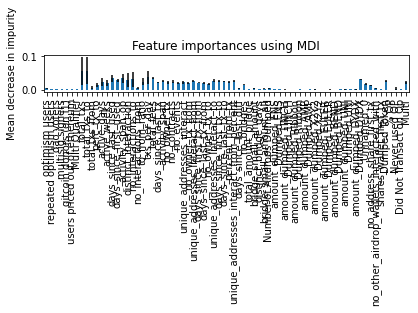

In [64]:
import pandas as pd
feature_names = [f"{i}" for i in X.columns]
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [65]:
X_test['y_test'] = y_test 
X_test['y_pred'] = y_pred_xgb 
X_test['prob'] = pd.Series(y_pred_rf_prob[:,1])
X_test['High'] = X_test['prob'].apply(lambda x: 1 if (x > .8) else 0)
df.iloc[X_test[X_test['y_test'] != X_test['y_pred']].index,:].to_csv('Why.csv')
high = df.iloc[X_test[(X_test['y_test'] != X_test['y_pred']) & (X_test['High'] == 1)].index,:]
high_right = df.iloc[X_test[(X_test['High'] == 1)].index,:]
print(f"High Probability of Being Classsifed As Dumpor: {len(high_right) / (len(X_test))}")
print(f"High Prbability Inaccuracy: {len(high) / len(high_right)}")

High Probability of Being Classsifed As Dumpor: 0.1659746405929101
High Prbability Inaccuracy: 0.1452589105581708


In [66]:
sybils_mayb = high_right[high_right['optimism users'] == 1]
sybils_high = high[high['optimism users'] == 1]
print(f'# of Wallets Identified with Sybil Behavior: {len(sybils_mayb)}')
print(f"Percent of Wallets that Were Did not Dump but showed High Sybil behavior: {len(sybils_high) / len(sybils_mayb)}")

# of Wallets Identified with Sybil Behavior: 2982
Percent of Wallets that Were Did not Dump but showed High Sybil behavior: 0.12541918175720992


In [67]:
forest_importances.sort_values(ascending=False).head(50)

total_txs_to                                0.056980
total_txs                                   0.056128
txs_per_day                                 0.037366
total_fees                                  0.034630
days_since_last_used                        0.034211
activity_span_op                            0.033827
Dumped DYDX                                 0.031848
no_interactions_to                          0.031167
distinct_interaction                        0.029114
days_since_first_used                       0.028003
unique_addresses_interact_to                0.027634
days_since_first_tx_to                      0.026632
unique_addresses_interact_from              0.026574
activity_span                               0.025872
unique_addresses_interact_from_percent      0.025720
days_since_last_tx_to                       0.025500
Dumped Token                                0.025104
no_contracts                                0.023820
percent_from_tx                             0.

In [68]:
post = pd.merge(df_hop_airdrop,df_op,left_on='airdrop_recipient',right_on='user',how='left')
post = post.fillna(0)
post

,Unnamed: 0_x,airdrop_recipient,time_airdrop_claimed,days_since_claim,amount,optimism users,repeated optimism users,dao voters,multisig signers,gitcoin donors (on l1),...,active_weeks,days_since_last_used,days_since_first_used,activity_span_op,distinct_interaction,no_interactions_to,no_interactions_from,to_from_ratio,txs_per_day,total_fees
0,0,0x8de2a3587a6277b855f125af120fa69db3712129,2022-06-02 19:05:22.000,134,776.867362,1,0,0,0,0,...,3,128,149,21,5,5,2,2.500000,2.333333,0.002615
1,1,0xc3baf091d7282ab739c8e478e0b1159e90f44220,2022-06-01 05:46:22.000,135,776.867362,1,0,0,0,0,...,2,68,135,67,7,7,2,3.500000,4.500000,0.001448
2,2,0x5af84f1318241b4224ecfc9e6d4e97a3118cd38f,2022-05-31 18:19:30.000,136,1186.293655,0,0,0,0,0,...,3,22,165,143,12,12,1,12.000000,5.000000,0.005974
3,3,0x163e0934d4b1ef0f279989cc81071ec7429cfcff,2022-05-31 18:58:30.000,136,681.260072,0,0,0,0,0,...,1,136,136,0,4,4,1,4.000000,4.000000,0.003018
4,4,0xc6423efdfc0b74eb5f94ae018bbd01634a4051c4,2022-06-01 04:03:37.000,135,271.833779,0,0,1,0,0,...,1,135,135,0,2,2,1,2.000000,2.000000,0.000907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149314,49314,0x29f38539edd0af82ca268eab907651671a9fcddb,2022-05-31 17:37:00.000,136,271.833779,0,0,1,0,0,...,4,60,139,79,8,7,3,2.333333,2.600000,0.002791
149315,49315,0x5d5a7e3465b8dcaa2ce7362ea19e8dcad985dd88,2022-09-11 13:33:16.000,33,1462.101481,0,0,0,0,0,...,1,33,33,0,2,2,1,2.000000,2.000000,0.001682
149316,49316,0xbee267272f8be199fefd463708f22ec9a1ff50ab,2022-05-31 18:04:45.000,136,409.426293,0,0,0,0,0,...,3,109,139,30,4,4,2,2.000000,1.250000,0.001270
149317,49317,0x4d87ef681ab2f717fe0425099d79dfe773d52ca7,2022-06-01 18:31:42.000,135,776.867362,1,0,0,0,0,...,1,135,135,0,1,1,1,1.000000,1.000000,0.000761


In [69]:
df_hop_airdrop.iloc[8158,:]

Unnamed: 0                                                            8158
airdrop_recipient               0x4059d31c9c0f578b701309c595671bb29dd4def8
time_airdrop_claimed                               2022-06-01 06:40:07.000
days_since_claim                                                       135
amount                                                              681.26
optimism users                                                           0
repeated optimism users                                                  0
dao voters                                                               0
multisig signers                                                         0
gitcoin donors (on l1)                                                   0
users priced out of ethereum                                             0
delegator                                                                0
curent_op_balance                                                        0
op_percent_change        

<AxesSubplot:title={'center':'Active Weeks for Dumpers on Optimism'}, xlabel='dumped', ylabel='active_weeks'>

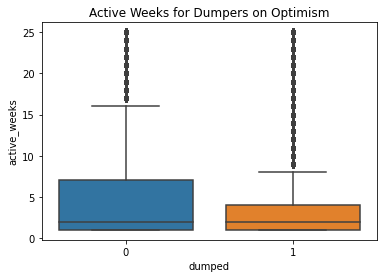

In [70]:
plt.title('Active Weeks for Dumpers on Optimism')
sns.boxplot(data=post, x="dumped", y="active_weeks")

In [71]:
post_dump = post[post['dumped'] == 1]
print('Stats for those to dump $OP')
print(post[post['dumped'] == 1][['active_weeks','active_days','activity_span_op']].describe())
print('Stats for those to keep $OP')
print(post[post['dumped'] == 0][['active_weeks','active_days','activity_span_op']].describe())

Stats for those to dump $OP
        active_weeks    active_days  activity_span_op
count  116344.000000  116344.000000     116344.000000
mean        3.466780       5.751745         47.845321
std         4.231286      11.050503         56.548821
min         1.000000       1.000000          0.000000
25%         1.000000       1.000000          0.000000
50%         2.000000       2.000000         15.000000
75%         4.000000       5.000000        103.000000
max        25.000000     172.000000        171.000000
Stats for those to keep $OP
       active_weeks   active_days  activity_span_op
count  32975.000000  32975.000000      32975.000000
mean       5.148537      9.080000         64.510751
std        5.911373     15.091467         63.365064
min        1.000000      1.000000          0.000000
25%        1.000000      1.000000          0.000000
50%        2.000000      3.000000         55.000000
75%        7.000000     10.000000        128.000000
max       25.000000    172.000000        1

In [72]:
post_dump = post[post['dumped'] == 1]
print('Stats for those to dump $OP')
print(post[post['dumped'] == 1][['total_txs','distinct_interaction','total_fees']].describe())
print('Stats for those to keep $OP')
print(post[post['dumped'] == 0][['total_txs','distinct_interaction','total_fees']].describe())

Stats for those to dump $OP
           total_txs  distinct_interaction    total_fees
count  116344.000000         116344.000000  1.163440e+05
mean       49.668320              9.131232  1.035060e-02
std      1437.089366             14.126036  3.675919e-01
min         1.000000              1.000000  1.223120e-07
25%         5.000000              4.000000  1.231578e-03
50%         7.000000              5.000000  2.006955e-03
75%        14.000000              8.000000  3.768533e-03
max    150603.000000           1509.000000  6.592612e+01
Stats for those to keep $OP
          total_txs  distinct_interaction    total_fees
count  32975.000000          32975.000000  3.297500e+04
mean      42.463988             12.689704  7.105693e-03
std      344.818606             20.519367  1.398750e-01
min        1.000000              1.000000  8.888000e-08
25%        3.000000              2.000000  8.848149e-04
50%        7.000000              5.000000  1.794659e-03
75%       29.000000             13.0000

In [73]:
post['Time Between Airdrop & Last Using OP'] = post['days_since_claim'] - post['days_since_last_used']

<AxesSubplot:xlabel='dumped', ylabel='Time Between Airdrop & Last Using OP'>

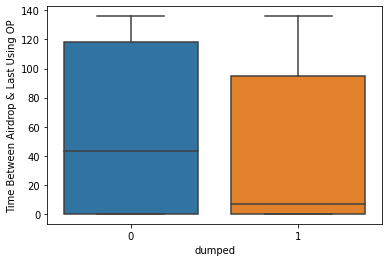

In [74]:
sns.boxplot(x='dumped',y='Time Between Airdrop & Last Using OP',data=post)

In [75]:
post_dump = post[post['dumped'] == 1]
print('Stats for those to dump $OP')
print(post[post['dumped'] == 1][['Time Between Airdrop & Last Using OP']].describe())
print('Stats for those to keep $OP')
print(post[post['dumped'] == 0][['Time Between Airdrop & Last Using OP']].describe())

Stats for those to dump $OP
       Time Between Airdrop & Last Using OP
count                         116344.000000
mean                              42.496571
std                               51.555504
min                                0.000000
25%                                0.000000
50%                                7.000000
75%                               95.000000
max                              136.000000
Stats for those to keep $OP
       Time Between Airdrop & Last Using OP
count                          32975.000000
mean                              56.040819
std                               56.350163
min                                0.000000
25%                                0.000000
50%                               43.000000
75%                              118.000000
max                              136.000000


In [76]:
post_d = post[post['dumped'] == 0]
post_d[['time_airdrop_claimed','days_since_claim','days_since_last_used','Time Between Airdrop & Last Using OP']].sort_values('days_since_last_used')

,time_airdrop_claimed,days_since_claim,days_since_last_used,Time Between Airdrop & Last Using OP
106470,2022-06-01 00:22:07.000,135,0,135
86972,2022-05-31 18:48:15.000,136,0,136
30224,2022-06-02 11:05:43.000,134,0,134
119661,2022-06-01 09:50:40.000,135,0,135
119907,2022-06-01 01:31:07.000,135,0,135
...,...,...,...,...
55415,2022-05-31 23:04:52.000,136,136,0
81588,2022-05-31 23:40:37.000,136,136,0
134722,2022-05-31 23:19:37.000,136,136,0
32923,2022-05-31 23:27:07.000,136,136,0


In [77]:
post['Didnt use OP - 3 Days'] = post['Time Between Airdrop & Last Using OP'].apply(lambda x:1 if x < 3 else 0)
post['Didnt use OP - 7 Days'] = post['Time Between Airdrop & Last Using OP'].apply(lambda x:1 if x < 7 else 0)
post['Didnt use OP - 30 Days'] = post['Time Between Airdrop & Last Using OP'].apply(lambda x:1 if x < 30 else 0)
post['Used in Past 14 Days'] = post['days_since_last_used'].apply(lambda x:1 if x < 14 else 0)

xx = pd.DataFrame(post.groupby('dumped')['Didnt use OP - 3 Days'].sum()).rename(columns={'airdrop_recipient':'Didnt use OP - 3 Day'}).reset_index()
xx7 = pd.DataFrame(post.groupby('dumped')['Didnt use OP - 7 Days'].sum()).rename(columns={'airdrop_recipient':'Didnt use OP - 7 Day'}).reset_index()
xx30 = pd.DataFrame(post.groupby('dumped')['Didnt use OP - 30 Days'].sum()).rename(columns={'airdrop_recipient':'Used OP for over a Mont'}).reset_index()
xx14 = pd.DataFrame(post.groupby('dumped')['Used in Past 14 Days'].sum()).rename(columns={'airdrop_recipient':'Used in Past 14 Days'}).reset_index()
xx = pd.merge(xx,xx7,left_on='dumped',right_on='dumped')
xx= pd.merge(xx,xx30,left_on='dumped',right_on='dumped')
xx= pd.merge(xx,xx14,left_on='dumped',right_on='dumped')
# xx  = xx.drop(columns=['Use OP - 30 Days','Didnt use OP - 3 Days','Didnt use OP - 7 Days'])
xx['Didnt use OP - 3 Days'] =  (xx['Didnt use OP - 3 Days'] / len(post))
xx['Didnt use OP - 7 Days'] =  (xx['Didnt use OP - 7 Days'] / len(post))
xx['Didnt use OP - 30 Days'] =   (xx['Didnt use OP - 30 Days'] / len(post))
xx['Used in Past 14 Days'] = xx['Used in Past 14 Days'] / len(post)
# xx  = xx.drop(columns=['Didnt use OP - 3 Day','Didnt use OP - 7 Day','Used OP for over a Mont'])
xx

,dumped,Didnt use OP - 3 Days,Didnt use OP - 7 Days,Didnt use OP - 30 Days,Used in Past 14 Days
0,0,0.091341,0.094275,0.106925,0.054574
1,1,0.359345,0.384740,0.462145,0.109370


In [78]:
yy = pd.DataFrame()
cols = ['Multi Qualifier','optimism users','repeated optimism users','dao voters','multisig signers','gitcoin donors (on l1)', 'users priced out of ethereum']
for col in cols:
    airdrop = post[df_hop_airdrop[col] == 1]
    xx = pd.DataFrame(airdrop.groupby('Didnt use OP - 3 Days')['airdrop_recipient'].count()).rename(columns={'airdrop_recipient':'% Didnt use OP - 3 Days'}).reset_index()
    xx7 = pd.DataFrame(airdrop.groupby('Didnt use OP - 7 Days')['airdrop_recipient'].count()).rename(columns={'airdrop_recipient':'% Didnt use OP - 7 Days'}).reset_index()
    xx30 = pd.DataFrame(airdrop.groupby('Didnt use OP - 30 Days')['airdrop_recipient'].count()).rename(columns={'airdrop_recipient':'% Didnt use OP - 30 Days'}).reset_index()
    xx = pd.merge(xx,xx7,left_on='Didnt use OP - 3 Days',right_on='Didnt use OP - 7 Days')
    xx= pd.merge(xx,xx30,left_on='Didnt use OP - 3 Days',right_on='Didnt use OP - 30 Days')
    xx  = xx.drop(columns=['Didnt use OP - 3 Days','Didnt use OP - 7 Days','Didnt use OP - 30 Days'])
    xx['% Didnt use OP - 3 Days'] = xx['% Didnt use OP - 3 Days'] / len(airdrop)
    xx['% Didnt use OP - 7 Days'] = xx['% Didnt use OP - 7 Days'] / len(airdrop)
    xx['% Didnt use OP - 30 Days'] = xx['% Didnt use OP - 30 Days'] / len(airdrop)
    xx['OP Airdrop Type'] = col
    yy = pd.concat([xx,yy])
yy = yy.reset_index()
yy[yy['index'] == 1]

,index,% Didnt use OP - 3 Days,% Didnt use OP - 7 Days,% Didnt use OP - 30 Days,OP Airdrop Type
1,1,0.693558,0.725768,0.787867,users priced out of ethereum
3,1,0.539349,0.566898,0.657448,gitcoin donors (on l1)
5,1,0.766313,0.792362,0.851290,multisig signers
7,1,0.633967,0.658684,0.725399,dao voters
9,1,0.135332,0.158833,0.250855,repeated optimism users
11,1,0.368545,0.399044,0.513562,optimism users
13,1,0.366113,0.392454,0.473451,Multi Qualifier


In [ ]:
import shap

explainer = shap.TreeExplainer(rf)

shap_values = explainer.shap_values(X_test)

# # Make plot. Index of [1] is explained in text below.
# shap.summary_plot(shap_values[1], X_test)
shap.summary_plot(shap_values, plot_type='violin')

In [ ]:
# for i in df_hop_airdrop.columns:
#     try:
#         plt.figure()
#         plt.title(f'Historgram by Cluster - {i}')
#         sns.histplot(x=i,data=df_hop_airdrop)
#     except: 
#         a= 1

In [ ]:
plt.figure()
plt.title('Did a Address that Dumped a previous airdrop Dump $OP?')
sns.histplot(x = 'Number of Airdrops Dumped',data =df,hue = 'dumped_30',element='step',multiple='stack',bins =20)

In [ ]:
df.groupby(['Number of Airdrops Dumped','Within 30'])['airdrop_recipient'].count()

In [ ]:
df[df['address'] == '0x042a135bd342910ad7f67bbda74e3fd4125d1272']